# **Notebook for Time Series Analysis**



**Authors**: Tommaso Baroni, Luca Bestagno

**Dataset**: Electric Vehicle Temperature Dataset

**Kaggle Link**: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

## **Context**

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

## **Content**

All recordings are sampled at **2 Hz**. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". **A measurement session can be between one and six hours long**.

The motor is excited by hand-designed driving cycles denoting a reference **motor speed** and **a reference torque**.
Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

#### **Inspiration**

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/MyDrive/Colab Notebooks/Data Mining/measures_v2.csv'

df = pd.read_csv(file_path)
df.head(10)


Mounted at /content/drive


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17
5,-0.538973,18.901548,19.077108,0.009147,18.290628,0.009636,-0.613635,0.336747,24.573601,18.323862,19.850634,0.476218,17
6,-0.653148,18.941711,19.074583,0.238890,18.292524,0.001337,-1.005647,0.554211,24.576578,18.321936,19.850630,0.670015,17
7,-0.758392,18.960861,19.082499,0.395099,18.294041,0.001422,-1.288384,0.706370,24.574949,18.314655,19.850628,0.752035,17
8,-0.727128,18.973545,19.085533,0.546623,18.291964,0.000577,-1.490530,0.817339,24.567080,18.306925,19.850626,0.910541,17
9,-0.874307,18.987812,19.076025,0.578944,18.287233,-0.001248,-1.634464,0.898013,24.553242,18.301733,19.850624,0.924010,17


# **COLUMNS**

**u_q**

Voltage q-component measurement in dq-coordinates (in V)

**coolant**

Coolant temperature (in °C)

**stator_winding**

Stator winding temperature (in °C) measured with thermocouples

**u_d**

Voltage d-component measurement in dq-coordinates

**stator_tooth**

Stator tooth temperature (in °C) measured with thermocouples

**motor_speed**

Motor speed (in rpm)

**i_d**

Current d-component measurement in dq-coordinates

**i_q**

Current q-component measurement in dq-coordinates

**pm**

Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.

**stator_yoke**

Stator yoke temperature (in °C) measured with thermocouples

**ambient**

Temperature of the environment in which the test was performed (in °C)

**torque**

Resultant torque generated by the PMSM (in Nm)



# Dataset overview and Missing values

In [3]:
# Overview of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [4]:
# Number of Missing Value for each column
for column in df.columns:
    missing_values = df[column].isnull().sum()
    print(f"The column '{column}' has {missing_values} missing values")

The column 'u_q' has 0 missing values
The column 'coolant' has 0 missing values
The column 'stator_winding' has 0 missing values
The column 'u_d' has 0 missing values
The column 'stator_tooth' has 0 missing values
The column 'motor_speed' has 0 missing values
The column 'i_d' has 0 missing values
The column 'i_q' has 0 missing values
The column 'pm' has 0 missing values
The column 'stator_yoke' has 0 missing values
The column 'ambient' has 0 missing values
The column 'torque' has 0 missing values
The column 'profile_id' has 0 missing values


No missing values, so the dataset is already clean.

## Statistical Analysis

In [5]:
#Statistical Analysis of the Dataset
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


## Data Preprocessing

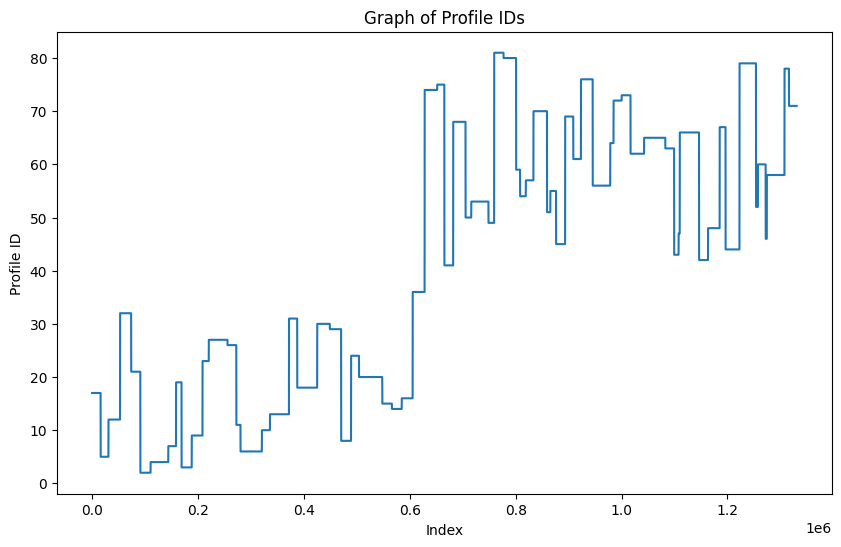

In [6]:
# Let's plot the profile ID values.

plt.figure(figsize=(10, 6))
plt.plot(df['profile_id'])
plt.title('Graph of Profile IDs')
plt.xlabel('Index')
plt.ylabel('Profile ID')
plt.show()

We observe that the profile ID values, which represent the test sessions, don't follow the right session measurements pattern.

In [7]:
#Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


In [8]:
#Sorting the value of the measurement sessions

#The 'mergesort' algorithm is a stable sort, meaning that it maintains the
#relative order of rows with equal 'profile_id' values. However, this code
#creates a new DataFrame sorted_df with the sorted data.
print(df.head(10))
df.sort_values(by='profile_id', kind='mergesort', inplace=True)
unique_values = df['profile_id'].unique()
print(unique_values)

        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   
5 -0.538973  18.901548       19.077108  0.009147     18.290628     0.009636   
6 -0.653148  18.941711       19.074583  0.238890     18.292524     0.001337   
7 -0.758392  18.960861       19.082499  0.395099     18.294041     0.001422   
8 -0.727128  18.973545       19.085533  0.546623     18.291964     0.000577   
9 -0.874307  18.987812       19.076025  0.578944     18.287233    -0.001248   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19

We notice that some of the "profile_id"s are missing.
This might be a result of certain measurement sections being omitted from the dataset due to measurement errors during the test or for reasons unknown to us.


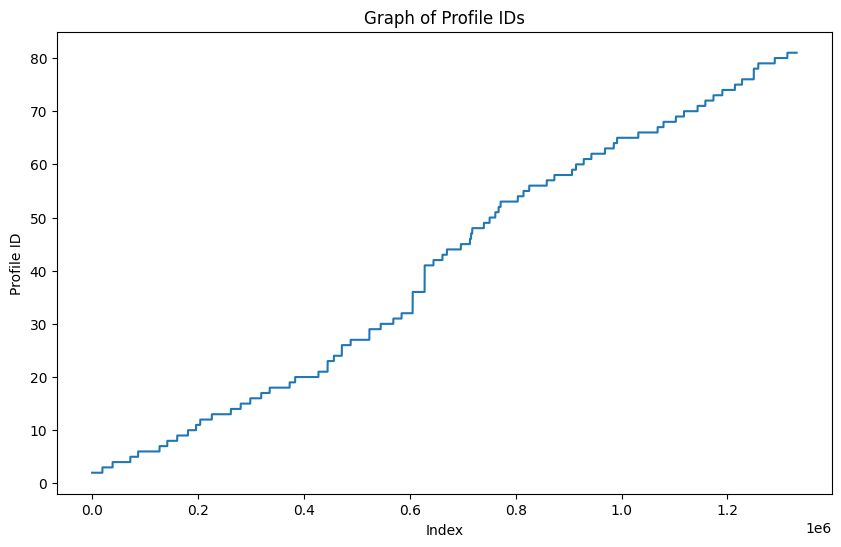

In [9]:
#Correcting the indexes of the sorting dataset
df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(df['profile_id'])
plt.title('Graph of Profile IDs')
plt.xlabel('Index')
plt.ylabel('Profile ID')
plt.show()

The sensors take the data with a frequence of 2 Hz, so every
0.5 secods.
Having to Study a time series, it is better to have for each unique measurement its time line.

In [ ]:
# Let's add a column to the dataset, which represents the actual time stamp, starting from 0, of each measurement in each session.

df['time'] = 0.0

previous_profile_id = None

for index, row in df.iterrows():
    if row['profile_id'] != previous_profile_id:
        # Reset increment when profile_id changes
        current_increment = 0.0
        previous_profile_id = row['profile_id']
    df.at[index, 'time'] = current_increment
    current_increment += 0.5

df.head()

## Session Lenghts

Let's see if each measurement test is between the 1 hour and 6 hours as said in the kaggle description.

In [ ]:
# First, group by 'profile_id' and find the maximum 'time' for each group
max_times = df.groupby('profile_id')['time'].max() / 3600

# Plot the results
max_times.plot.barh(figsize=(12,18), grid='both', title='Time per Session')
plt.xlabel('time (hr)')

## Correlations

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, various insights are shown:

+ i_q and torque are directly correlated. This is due to the fact that i_q is the current variable which is directly responsable to the torque control in PMSMs.
+ stator_yoke, stator_tooth and stator_winding, all temperatures related to the stator mechanical part, all share a high correlation among them.
+ stator_yoke also shows a high correlation (0.86) with the coolant variable, which is the coolant temperature.


## Plot of interesting variables to visualize the correlation between them.

In [ ]:
from itertools import cycle

temp_features = ['coolant', 'stator_tooth', 'stator_yoke', 'stator_winding']  # example features
dfui = df.columns

# Create a color list
color_list = plt.cm.tab10(np.linspace(0, 1, 10))

# Columns of interest
coi = temp_features + [c for c in dfui if c not in temp_features]

# Cycling through the color list
color_cycle = cycle(color_list)

# Creating a dictionary to map features to colors
feat_clrs = {k: rgb2hex(next(color_cycle)[:3]) for k in coi}


coi = temp_features

n_cols = 4
n_rows = np.ceil(len(grpd) / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    for c in coi:
        lines = ax.plot(df_[c].reset_index(drop=True), label=c, color=feat_clrs[c])
    ax.set_title(f'profile {p_id}')
    if i % n_cols == 0:
        ax.set_ylabel('Temp in °C')
    if i >= (len(grpd) - n_cols):
        ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

We can now drop the correlated variables.

In [ ]:
# Remove the specified columns
df.drop(['stator_tooth', 'coolant', 'stator_winding', 'torque'], axis=1, inplace=True)

In [ ]:
# Let's rename the stator_yoke variable to stator_temp
df.rename(columns={'stator_yoke': 'stator_temp'}, inplace=True)

# Check the first few rows to confirm the columns are removed
print(df.head())

In [ ]:
# Re-plot of the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

High-correlated values are still present in the dataset, like i_q and u_d, and i_d and motor_speed, but for now we decide to keep them, since the correlation is high but not too much. We also notice a strong correlation between stator_yoke and pm.

## Normalization

Let's normalize the motor_speed variable, since it is the only variable that has a range different from the others.

In [ ]:
# Create a MinMaxScaler object with the desired range
scaler = MinMaxScaler(feature_range=(0, 100))

# Reshape (-1, 1) is used because scaler expects 2D array
df['motor_speed_normalized'] = scaler.fit_transform(df[['motor_speed']])

# Check the first few rows to see the normalized values
print(df[['motor_speed', 'motor_speed_normalized']].head())

df.drop(['motor_speed'], axis=1, inplace=True)

In [ ]:
# Group the data by 'profile_id'
grouped = df.groupby('profile_id')

# Initialize a dictionary to store statistics for each profile_id and each feature
profile_stats = {}

# Calculate statistics for each profile_id and each feature
for profile_id, group_data in grouped:
    feature_stats = {}

    for feature in df.columns:
        if feature not in ['profile_id', 'time']:
            mean_value = group_data[feature].mean()

            feature_stats[f'Mean {feature}'] = mean_value


    # Store the statistics in the dictionary
    profile_stats[profile_id] = feature_stats

# Convert the dictionary to a DataFrame for easier analysis and visualization
profile_stats_df = pd.DataFrame.from_dict(profile_stats, orient='index')

# Print or analyze the statistics as needed
print(profile_stats_df)

In [ ]:
# Transpose the DataFrame for better visualization
profile_stats_df = profile_stats_df.T

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the mean values for each feature
num_profiles_to_plot = 5  # Adjust the number of profiles to plot as needed
colors = plt.cm.viridis(np.linspace(0, 1, num_profiles_to_plot))  # Choose a color map
profile_ids_to_plot = profile_stats_df.columns[:num_profiles_to_plot]

for i, profile_id in enumerate(profile_ids_to_plot):
    plt.bar(
        np.arange(len(profile_stats_df.index)) + i * 0.2,
        profile_stats_df[profile_id],
        width=0.2,
        label=f'Profile {profile_id}',
        color=colors[i]
    )

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.title('Mean Values for Each Feature by Profile ID')

# Set x-axis labels and adjust rotation if needed
plt.xticks(np.arange(len(profile_stats_df.index)) + 0.2 * (num_profiles_to_plot - 1) / 2, profile_stats_df.index, rotation=45)

# Create a simplified legend
plt.legend(loc='upper right', title='Profile IDs')

# Show the plot
plt.tight_layout()
plt.show()